In [3]:
import argparse 
import cv2
import numpy as np
import os
import glob
import random
import Utility
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
from keras.models import * 
from keras.layers import *

import numpy as np
import cv2
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from scipy.misc import imresize
import itertools

from sklearn.cross_validation import train_test_split 
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD

/home/surya/.conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/surya/.conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the augmented training data 

In [5]:
trainList = ["others","Melanoma/original","Melanoma/left_rotate","Melanoma/flip","Melanoma/right_rotate"]
class_id = 0
class_path = []
segs_path = []
classes = []
imgs_path = []
paths = []
Melanoma = []
for training_name in trainList:
    class_path = Utility.imlist(training_name)
    paths += class_path
    classes += [class_id] * len(class_path)
    class_id += 1
    if(class_id>1):
        class_id=1
    
    

# Loading the segmented image data

In [6]:
path = "gt"
gt_paths = []
for pt in paths:
    #print(pt)
    newfile = pt.split("/")[-1][0:-4]+ "_segmentation.png"
    newpath = path+"/" + newfile
    #print (newpath)
    gt_paths.append(newpath)
    

In [7]:
len(gt_paths)

3122

In [8]:
#for data augmentation
import shutil
for pt in range(0,1626):
    shutil.copy(gt_paths[pt],"GT/non_cancer")

In [9]:
#Melanoma Data is rotated along all the 4 directions 
path = ["GT/non_cancer","GT/original","GT/left_rotate","GT/flip","GT/right_rotate"]
gt_paths = []

i = 0
j = 0 
for pt in paths:
    #print(pt)
    newfile = pt.split("/")[-1][0:-4]+ "_segmentation.png"
    
    if(j==1626 or j == 2000 or j==2374 or j == 2748):
        i = i + 1 
    j = j + 1    
    newpath = path[i] +"/" + newfile
    
    #print (newpath)
    gt_paths.append(newpath)

In [10]:
norm_images = []
seg_images = []
for i in range(len(paths)):
    im = cv2.imread(paths[i])
    seg = cv2.imread(gt_paths[i],0)
    norm_images.append(im)
    seg_images.append(seg)

# Applying logical mask to the images

In [11]:
segmented = []

for i in range(len(norm_images)):
    img1 = cv2.resize(norm_images[i], (128,128))
    img2 = cv2.resize(seg_images[i], (128,128))
    
    #print(img1.shape)
    #print(img2.shape)
    B,G,R = cv2.split(img1)
    maskB = np.multiply(B,img2)
    maskG = np.multiply(G,img2)
    maskR = np.multiply(R,img2)
    img = cv2.merge((maskB,maskG,maskR))
    segmented.append(img)


In [12]:
segemented = np.array(segmented)
norm_images = np.array(norm_images)
seg_images = np.array(seg_images)

In [69]:
np.save("segemented.npy",segmented)
np.save("norm_images.npy",norm_images)
np.save("seg_images.npy",seg_images)

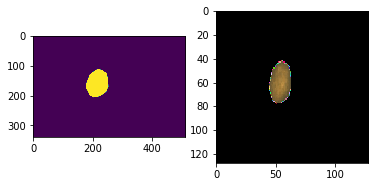

In [13]:
plt.subplot(1,2,1)
plt.imshow(seg_images[0])

plt.subplot(1,2,2)
plt.imshow(segemented[0])

# Splitting the data into testing and training

In [14]:
other_seg = segemented[0:1326]
mela_seg = segemented[1626:1950]
mela_seg2 = segemented[2000:2324]
mela_seg3 = segemented[2374:2698]
mela_seg4 = segemented[2748:3072]
x_train = np.concatenate((other_seg,mela_seg,mela_seg2,mela_seg3,mela_seg4),axis=0)

In [15]:
other_segt = segemented[1326:1626]
mela_segt = segemented[1950:2000]
mela_seg2t = segemented[2324:2374]
mela_seg3t = segemented[2698:2748]
mela_seg4t = segemented[3072:3122]


x_test = np.concatenate((other_segt,mela_segt,mela_seg2t,mela_seg3t,mela_seg4t),axis=0)

In [16]:
x_test.shape

(500, 128, 128, 3)

In [17]:
y_train = np.concatenate((classes[:1326],classes[1626:1950],classes[2000:2324],classes[2374:2698],classes[2748:3072]),axis=0)
y_test = np.concatenate((classes[1326:1626],classes[1950:2000],classes[2324:2374],classes[2698:2748],classes[3072:3122]),axis=0)

In [18]:
y_test.shape

(500,)

In [19]:
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

y_train = LabelEncoder().fit_transform(y_train)
y_train = np_utils.to_categorical(y_train)
y_test = LabelEncoder().fit_transform(y_test)
y_test = np_utils.to_categorical(y_test)

In [20]:
y_test.shape

(500, 2)

# CNN Model with 6 Layer

In [23]:
Optimizer=Adam(lr=0.001)
objective='binary_crossentropy'
def center_normalize(x):
    return (x-K.mean(x))/K.std(x)
model=Sequential()
#input layer
model.add(Activation(activation=center_normalize, input_shape=(128, 128,3)))
# convolutional layer
model.add(Convolution2D(32,5,5,border_mode='same',activation='relu',dim_ordering='tf'))
#pooling layer
model.add(MaxPooling2D(pool_size=(2,2),dim_ordering='tf'))
# convolutional layer
model.add(Convolution2D(64,3,3,border_mode='same',activation='relu',dim_ordering='tf'))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2),dim_ordering='tf'))
model.add(Flatten())
# Relu 
model.add(Dense(128, activation='relu'))
# Sigmoid Fully connected layer
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss=objective,optimizer=Optimizer,metrics=['accuracy'])

/home/surya/.conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same", data_format="channels_last")`
  if __name__ == '__main__':
/home/surya/.conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  # This is added back by InteractiveShellApp.init_path()
/home/surya/.conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same", data_format="channels_last")`
  del sys.path[0]
/home/surya/.conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  from ipykernel import kernelapp as app


In [30]:
model.fit(x_train,y_train,batch_size=50,nb_epoch=20,verbose=1)


/home/surya/.conda/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
2622/2622 [==============================] - 96s 37ms/step - loss: 0.3208 - acc: 0.8602
Epoch 2/20
2622/2622 [==============================] - 99s 38ms/step - loss: 0.2349 - acc: 0.9113
Epoch 3/20
2622/2622 [==============================] - 99s 38ms/step - loss: 0.1670 - acc: 0.9382
Epoch 4/20
2622/2622 [==============================] - 101s 39ms/step - loss: 0.1042 - acc: 0.9636
Epoch 5/20
2622/2622 [==============================] - 103s 39ms/step - loss: 0.0653 - acc: 0.9813
Epoch 6/20
2622/2622 [==============================] - 106s 40ms/step - loss: 0.0451 - acc: 0.9884
Epoch 7/20
2622/2622 [==============================] - 105s 40ms/step - loss: 0.0219 - acc: 0.9956
Epoch 8/20
2622/2622 [==============================] - 108s 41ms/step - loss: 0.0150 - acc: 0.9987
Epoch 9/20
2622/2622 [==============================] - 105s 40ms/step - loss: 0.0081 - acc: 0.9996
Epoch 10/20
2622/2622 [==============================] - 106s 40ms/step - loss: 0.0041 - acc: 1.0000
Ep

In [31]:
from sklearn.metrics import classification_report
Y_test = np.argmax(y_test,axis=1)

In [32]:
y_pred = model.predict_classes(x_test)

In [33]:
y_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,

# Classification Report

In [34]:
print(classification_report(Y_test,y_pred))

             precision    recall  f1-score   support

          0       0.72      0.65      0.68       300
          1       0.54      0.61      0.57       200

avg / total       0.64      0.63      0.64       500



In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_5 (Activation)    (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8388736   
__________